# Load packages

In [1]:
from IPython.core.display import display, HTML
import warnings
display(HTML("<style>.container { width:95% !important; }</style>"))
warnings.filterwarnings('ignore')

/tmp/ipykernel_2678/4155479159.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import sys
import os

#sys.path.append('C:/Users/karlan/Google Drive/Python/Projects/Anna') #Folder that contains "cell_tracking.py" file
#from cell_tracking import *

path = '/mnt/z/CellTracking/Final/Analyzed data/LGK/'

In [3]:
sys.path.append('/mnt/g/My Drive/Python/Projects/Anna')

from cell_tracking_basic_v1 import *
from cell_tracking_plotting_v1 import *

## Package versions

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

json==2.0.9
numpy==1.21.2
pandas==1.4.1
seaborn==0.11.2
read_roi==1.6.0
matplotlib==3.5.1


# Combine datasets

In [5]:
# Left here for information. In the main combining notebook this was used for additional annotation of the combined csv
experiments = {
    '20210521_LGK.csv': {'Name':'LGK', 'Start': 81, 'Crypt': 21},
    '20210521_LGK_ctrl.csv': {'Name':'LGK_ctrl', 'Start': 81, 'Crypt': 23},
    '20210702_LGK.csv': {'Name':'LGK', 'Start': 117, 'Crypt': 49},
    '20210702_LGK_ctrl.csv': {'Name':'LGK_ctrl', 'Start': 117, 'Crypt': 30},
    '20210709_LGK.csv': {'Name':'LGK', 'Start': 67, 'Crypt': 43},
    '20210709_LGK_ctrl.csv': {'Name':'LGK_ctrl', 'Start': 67, 'Crypt': 33}
}

In [6]:
cell_df = pd.concat([pd.read_csv(os.path.join(path, f), sep = ',') for f in experiments.keys()], keys = experiments.keys())
cell_df = cell_df.reset_index(level = 0).rename(columns = {'level_0': 'Name'}).reset_index(drop = True)
cell_df['Experiment'] = [experiments[f]['Name'] for f in cell_df['Name']]

In [7]:
cell_df

,Name,ID,Label,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,cumulative_distance_xyz,cumulative_distance_z,end_x,end_y,end_z,end_t,Live_dead,origin_class,end_class,Experiment
0,20210521_LGK.csv,7602,ID7602,14,21.308,507.972,64.268,14.848,0,0,...,0.000000,0.000,520.111,658.826,21.23,238.0,Alive,crypt,crypt,LGK
1,20210521_LGK.csv,8594,ID8594,14,17.274,504.913,62.340,15.260,120,1,...,3.639287,0.412,520.111,658.826,21.23,238.0,Alive,crypt,crypt,LGK
2,20210521_LGK.csv,8706,ID8706,14,16.308,503.074,62.246,17.206,240,2,...,6.318405,2.358,520.111,658.826,21.23,238.0,Alive,crypt,crypt,LGK
3,20210521_LGK.csv,9049,ID9049,14,15.541,502.365,62.150,16.643,360,3,...,7.228826,2.921,520.111,658.826,21.23,238.0,Alive,crypt,crypt,LGK
4,20210521_LGK.csv,8196,ID8196,14,14.889,502.322,62.795,19.731,480,4,...,10.383761,6.009,520.111,658.826,21.23,238.0,Alive,crypt,crypt,LGK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54454,20210709_LGK_ctrl.csv,318544,ID318544,4539,-1.000,311.938,26.336,70.000,115,115,...,170.546531,47.500,312.173,692.790,70.00,238.0,Alive,crypt,crypt,LGK_ctrl
54455,20210709_LGK_ctrl.csv,318540,ID318540,4539,-1.000,310.300,25.049,70.000,116,116,...,172.629657,47.500,312.173,692.790,70.00,238.0,Alive,crypt,crypt,LGK_ctrl
54456,20210709_LGK_ctrl.csv,318536,ID318536,4539,-1.000,311.002,26.336,70.000,117,117,...,174.095663,47.500,312.173,692.790,70.00,238.0,Alive,crypt,crypt,LGK_ctrl
54457,20210709_LGK_ctrl.csv,318532,ID318532,4539,-1.000,310.300,25.751,70.000,118,118,...,175.009462,47.500,312.173,692.790,70.00,238.0,Alive,crypt,crypt,LGK_ctrl


In [8]:
# Correct for imaging starting time after seeding
fastest_time = 0
cell_df['t_raw'] = cell_df['t']
cell_df['t'] = [t+experiments[f]['Start'] if (experiments[f]['Start']%2)==0 else t+experiments[f]['Start']+1 for f, t in cell_df[['Name', 't']].values] #make sure that all t-values are even (otherwise results in crazy fluctuations)

cell_df['z_crypt'] = [z-experiments[f]['Crypt'] for f, z in cell_df[['Name', 'z']].values]

In [9]:
measures = ['distance_z', 'z', 'difference_from_origin_z', 'distance_xy', 'distance_xyz']

for measure in measures:
    cell_df['{}_fit'.format(measure)] = np.nan
    
deg = 20
for ix, e in enumerate(cell_df['Name'].unique()):
    tmp = cell_df[cell_df['Name']==e]
    for track in set(tmp['track_reindexed']):
        tmp2 = tmp[tmp['track_reindexed']==track]
        t = tmp2['t'].values
        for measure in measures:
            z = tmp2[measure].values
            z_fit = np.poly1d(np.polyfit(x = t, y = z, deg = deg))(t)
            cell_df.loc[tmp2.index, '{}_fit'.format(measure)] = z_fit
            
            #print('{}/{}'.format(ix, len(cell_df['Name'].unique())))
            print(e)
            print(track)
            clear_output(wait = True)
            
cell_df['distance_from_origin_z'] = cell_df['difference_from_origin_z']

20210709_LGK_ctrl.csv
116


# Save combined dataset

In [10]:
cell_df.to_csv(os.path.join(path, 'LGK_combined_20211001.csv'))

# Make plots

(0.0, 4.0)

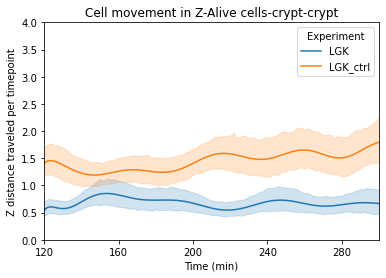

In [10]:
Location = cell_df[(cell_df['FRAME']!=0) & (cell_df['origin_class']=='crypt') & (cell_df['end_class']=='crypt') & (cell_df['Live_dead']=='Alive')]

sbn.lineplot(data= Location, x = 't', y = 'distance_z_fit', hue = 'Experiment')
plt.xlabel('Time (min)')
plt.ylabel('Z distance traveled per timepoint')
plt.title('Cell movement in Z-Alive cells-crypt-crypt')
plt.xticks(np.arange(0,max(cell_df['t']), 40))
plt.xlim([120,300])
plt.ylim([0,4])

(0.0, 4.0)

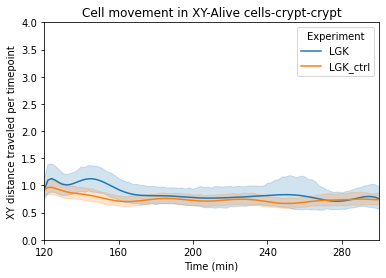

In [11]:
Location = cell_df[(cell_df['FRAME']!=0) & (cell_df['origin_class']=='crypt') & (cell_df['end_class']=='crypt') & (cell_df['Live_dead']=='Alive')]

sbn.lineplot(data= Location, x = 't', y = 'distance_xy_fit', hue = 'Experiment')
plt.xlabel('Time (min)')
plt.ylabel('XY distance traveled per timepoint')
plt.title('Cell movement in XY-Alive cells-crypt-crypt')
plt.xticks(np.arange(0,max(cell_df['t']), 40))
plt.xlim([120,300])
plt.ylim([0,4])

(0.0, 4.0)

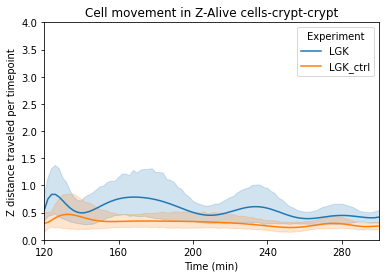

In [12]:
Location = cell_df[(cell_df['FRAME']!=0) & (cell_df['origin_class']=='villi') & (cell_df['end_class']=='villi') & (cell_df['Live_dead']=='Alive')]
sbn.lineplot(data= Location, x = 't', y = 'distance_z_fit', hue = 'Experiment')
plt.xlabel('Time (min)')
plt.ylabel('Z distance traveled per timepoint')
plt.title('Cell movement in Z-Alive cells-crypt-crypt')
plt.xticks(np.arange(0,max(cell_df['t']), 40))
plt.xlim([120,300])
plt.ylim([0,4])

(0.0, 4.0)

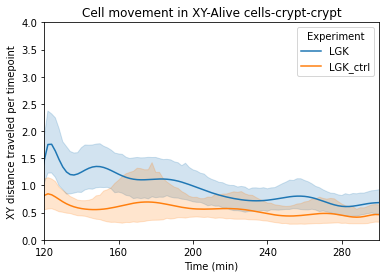

In [13]:
Location = cell_df[(cell_df['FRAME']!=0) & (cell_df['origin_class']=='villi') & (cell_df['end_class']=='villi') & (cell_df['Live_dead']=='Alive')]
sbn.lineplot(data= Location, x = 't', y = 'distance_xy_fit', hue = 'Experiment')
plt.xlabel('Time (min)')
plt.ylabel('XY distance traveled per timepoint')
plt.title('Cell movement in XY-Alive cells-crypt-crypt')
plt.xticks(np.arange(0,max(cell_df['t']), 40))
plt.xlim([120,300])
plt.ylim([0,4])